<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/for1Pic_Jan2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary Libraries

In [1]:
from google.colab import files
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Upload Dataset

Saving Mona_Lisa.jpg to Mona_Lisa.jpg


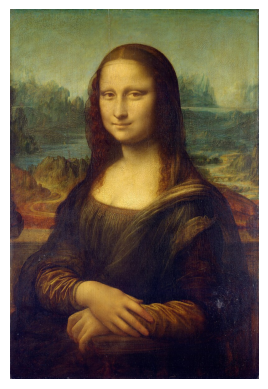

In [2]:
# Upload the file
uploaded = files.upload()

# Open the image using PIL
image = Image.open('Mona_Lisa.jpg')

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

# Create Mask

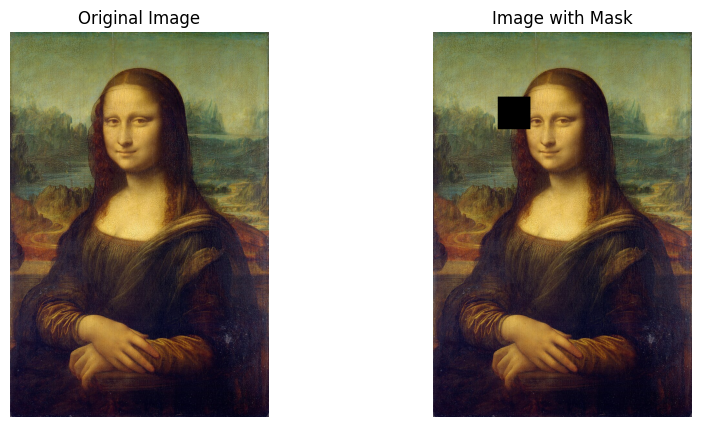

In [3]:
# Create a copy of the image to draw on
masked_image = image.copy()

# Define the square's position and size (left, upper, right, lower)
left = 200
upper = 200
right = 300
lower = 300

# Draw the mask (a filled rectangle) on the image
draw = ImageDraw.Draw(masked_image)
draw.rectangle([left, upper, right, lower], fill=(0, 0, 0, 128))  # Red color with transparency

# Display the original and masked images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.title('Original Image')

# Masked Image
plt.subplot(1, 2, 2)
plt.imshow(masked_image)
plt.axis('off')  # Hide the axis
plt.title('Image with Mask')

plt.show()

# Create Model for Inpaint

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

class SpatialLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SpatialLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        # Gates
        self.gates = nn.Linear(input_size + hidden_size, 4 * hidden_size)

        # Initialize weights
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, input_, prev_hidden=None):
        batch_size = input_.size(0)

        if prev_hidden is None:
            zeros = torch.zeros(batch_size, self.hidden_size,
                              dtype=input_.dtype, device=input_.device)
            prev_hidden = (zeros, zeros)

        prev_hidden_state, prev_cell_state = prev_hidden

        # Concatenate input and previous hidden state
        combined = torch.cat((input_, prev_hidden_state), dim=1)

        # Calculate gates
        gates = self.gates(combined)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, dim=1)

        # Apply activations
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        # Update states
        cell_state = (forgetgate * prev_cell_state) + (ingate * cellgate)
        hidden_state = outgate * torch.tanh(cell_state)

        return hidden_state, cell_state

class InpaintingModel(nn.Module):
    def __init__(self, input_channels=3):
        super(InpaintingModel, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(input_channels + 1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # LSTM layers
        self.spatial_lstm = SpatialLSTMCell(256, 256)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, input_channels, kernel_size=3, padding=1)

    def forward(self, x, mask):
        # Concatenate input image and mask
        x = torch.cat([x, mask], dim=1)

        # Encoding
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))

        # Reshape for LSTM
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)

        # Apply LSTM
        hidden = None
        outputs = []
        for i in range(x.size(1)):
            hidden = self.spatial_lstm(x[:, i, :], hidden)
            outputs.append(hidden[0])

        # Reshape back
        x = torch.stack(outputs, dim=1)
        x = x.permute(0, 2, 1).view(batch_size, channels, height, width)

        # Decoding
        x = F.interpolate(x, scale_factor=2)
        x = F.relu(self.deconv1(x))
        x = F.interpolate(x, scale_factor=2)
        x = F.relu(self.deconv2(x))
        x = torch.tanh(self.deconv3(x))

        return x

# Training function
def train_model(model, train_loader, optimizer, criterion, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, mask) in enumerate(train_loader):
            data, mask = data.to(device), mask.to(device)

            optimizer.zero_grad()
            output = model(data, mask)
            loss = criterion(output, data)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}')

# Preprocessing function
def preprocess_image(image_path, mask_size=(64, 64)):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path)
    image_tensor = transform(image)

    # Create mask
    mask = torch.zeros(1, 256, 256)
    center = 128
    half_size = mask_size[0] // 2
    mask[:, center-half_size:center+half_size, center-half_size:center+half_size] = 1

    return image_tensor.unsqueeze(0), mask.unsqueeze(0)

# Example usage
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model
    model = InpaintingModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Load and preprocess image
    image_tensor, mask = preprocess_image('Mona_Lisa.jpg')
    image_tensor, mask = image_tensor.to(device), mask.to(device)

    # Infer
    model.eval()
    with torch.no_grad():
        output = model(image_tensor, mask)

    # Convert output to image
    output = output.cpu().squeeze(0)
    output = output * 0.5 + 0.5  # Denormalize
    output = transforms.ToPILImage()(output)

    return output

# Added Optimizer

In [10]:
model = InpaintingModel().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
image_tensor, mask = preprocess_image('Mona_Lisa.jpg')

# Train the Model

In [12]:
train_model(model, [(image_tensor, mask)], optimizer, nn.MSELoss(), device='cuda')

Epoch 1/10, Loss: 0.4413
Epoch 2/10, Loss: 0.1654
Epoch 3/10, Loss: 0.2779
Epoch 4/10, Loss: 0.3297
Epoch 5/10, Loss: 0.1288
Epoch 6/10, Loss: 0.0589
Epoch 7/10, Loss: 0.0990
Epoch 8/10, Loss: 0.0587
Epoch 9/10, Loss: 0.0452
Epoch 10/10, Loss: 0.0566


# Image Inpainting Evaluation and Visualization

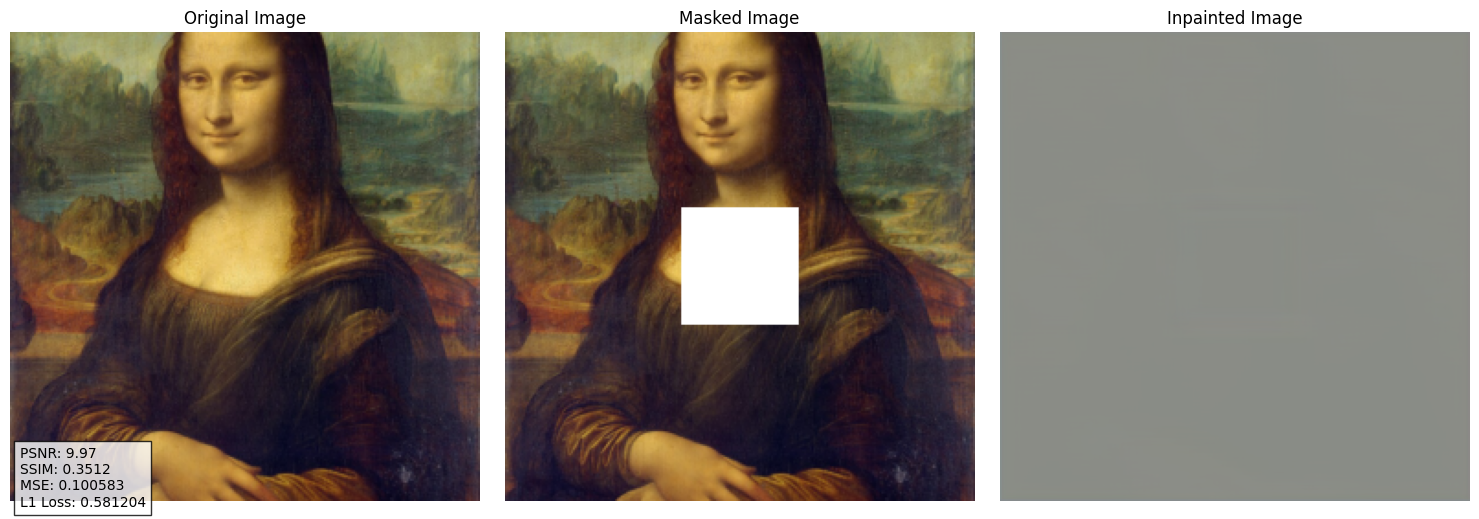


Evaluation Metrics:
PSNR: 9.97 dB
SSIM: 0.3512
MSE: 0.100583
L1 Loss: 0.581204


In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torchvision.transforms as transforms
from PIL import Image

class InpaintingEvaluator:
    def __init__(self):
        self.metrics = {}

    @staticmethod
    def tensor_to_numpy(tensor):
        """Convert tensor to numpy array and denormalize."""
        img = tensor.cpu().clone()
        img = img.squeeze(0)  # Remove batch dimension
        img = img * 0.5 + 0.5  # Denormalize
        img = img.permute(1, 2, 0).numpy()  # Change to HWC format
        img = np.clip(img, 0, 1)
        return img

    def calculate_mse(self, original, generated):
        """Calculate Mean Squared Error."""
        original = self.tensor_to_numpy(original)
        generated = self.tensor_to_numpy(generated)
        mse = np.mean((original - generated) ** 2)
        return mse

    def calculate_psnr(self, original, generated):
        """Calculate Peak Signal-to-Noise Ratio."""
        original = self.tensor_to_numpy(original)
        generated = self.tensor_to_numpy(generated)
        return psnr(original, generated)

    def calculate_ssim(self, original, generated):
        """Calculate Structural Similarity Index."""
        original = self.tensor_to_numpy(original)
        generated = self.tensor_to_numpy(generated)
        return ssim(original, generated, channel_axis=2, data_range=1.0)

    def calculate_l1_loss(self, original, generated):
        """Calculate L1 (Mean Absolute Error) Loss."""
        criterion = nn.L1Loss()
        return criterion(generated, original).item()

    def evaluate(self, original, masked, generated):
        """Calculate all metrics."""
        self.metrics['mse'] = self.calculate_mse(original, generated)
        self.metrics['psnr'] = self.calculate_psnr(original, generated)
        self.metrics['ssim'] = self.calculate_ssim(original, generated)
        self.metrics['l1_loss'] = self.calculate_l1_loss(original, generated)
        return self.metrics

    def visualize_results(self, original, masked, generated, save_path=None):
        """Visualize original, masked, and generated images side by side."""
        # Convert tensors to numpy arrays
        original_img = self.tensor_to_numpy(original)
        masked_img = self.tensor_to_numpy(masked)
        generated_img = self.tensor_to_numpy(generated)

        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot images
        axes[0].imshow(original_img)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(masked_img)
        axes[1].set_title('Masked Image')
        axes[1].axis('off')

        axes[2].imshow(generated_img)
        axes[2].set_title('Inpainted Image')
        axes[2].axis('off')

        # Add metrics as text
        metrics_text = f'PSNR: {self.metrics["psnr"]:.2f}\n'
        metrics_text += f'SSIM: {self.metrics["ssim"]:.4f}\n'
        metrics_text += f'MSE: {self.metrics["mse"]:.6f}\n'
        metrics_text += f'L1 Loss: {self.metrics["l1_loss"]:.6f}'

        plt.figtext(0.02, 0.02, metrics_text, fontsize=10,
                   bbox=dict(facecolor='white', alpha=0.8))

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

def evaluate_model(model, image_path, mask, device='cuda'):
    """Complete evaluation pipeline."""
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load original image
    original_image = Image.open(image_path)
    original_tensor = transform(original_image).unsqueeze(0).to(device)

    # Create masked image
    masked_tensor = original_tensor.clone()
    masked_tensor = masked_tensor * (1 - mask) + mask  # Apply mask

    # Generate inpainted image
    model.eval()
    with torch.no_grad():
        generated_tensor = model(masked_tensor, mask)

    # Initialize evaluator
    evaluator = InpaintingEvaluator()

    # Calculate metrics
    metrics = evaluator.evaluate(original_tensor, masked_tensor, generated_tensor)

    # Visualize results
    evaluator.visualize_results(original_tensor, masked_tensor, generated_tensor)

    return metrics

# Example usage
def main():
    # Load your trained model
    model = InpaintingModel().to('cuda')
    # Load your model weights here
    # model.load_state_dict(torch.load('model_weights.pth'))

    # Create mask (example)
    mask = torch.zeros(1, 1, 256, 256)
    center = 128
    mask[:, :, center-32:center+32, center-32:center+32] = 1
    mask = mask.to('cuda')

    # Evaluate
    metrics = evaluate_model(model, 'Mona_Lisa.jpg', mask)

    # Print metrics
    print("\nEvaluation Metrics:")
    print(f"PSNR: {metrics['psnr']:.2f} dB")
    print(f"SSIM: {metrics['ssim']:.4f}")
    print(f"MSE: {metrics['mse']:.6f}")
    print(f"L1 Loss: {metrics['l1_loss']:.6f}")

if __name__ == "__main__":
    main()

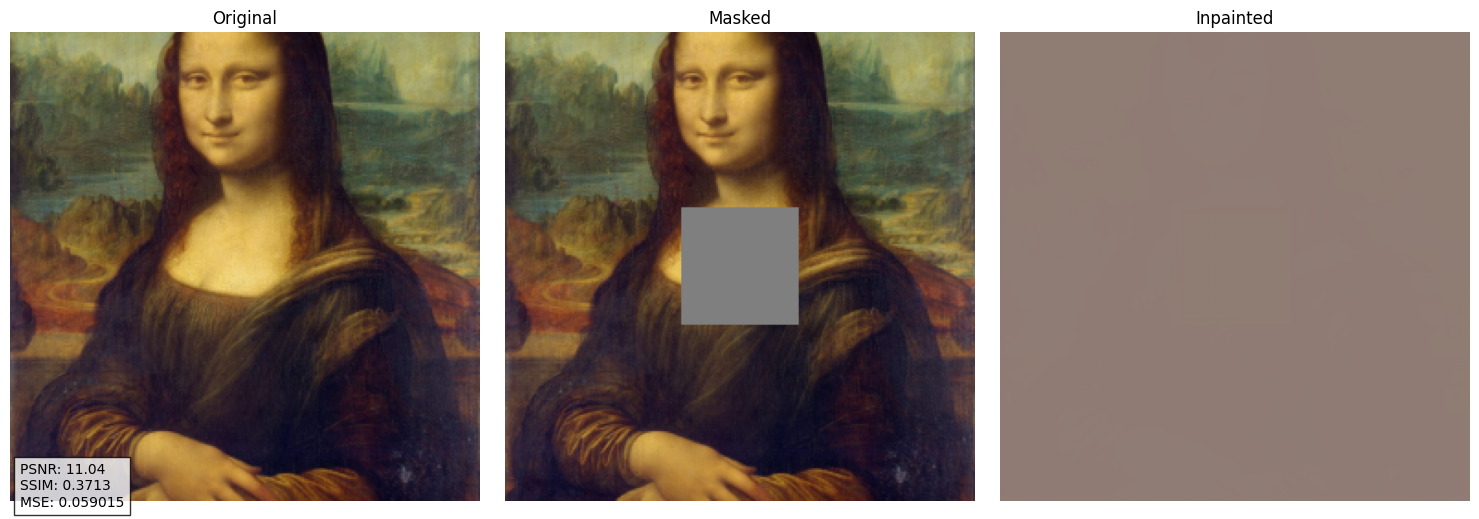


Evaluation Metrics:
PSNR: 11.04 dB
SSIM: 0.3713
MSE: 0.059015


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNetInpainting(nn.Module):
    def __init__(self):
        super(UNetInpainting, self).__init__()

        # Encoder
        self.conv1 = DoubleConv(4, 64)  # 4 channels: RGB + mask
        self.conv2 = DoubleConv(64, 128)
        self.conv3 = DoubleConv(128, 256)
        self.conv4 = DoubleConv(256, 512)
        self.conv5 = DoubleConv(512, 1024)

        # Decoder
        self.up_conv6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up_conv7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up_conv8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up_conv9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x, mask):
        # Concatenate input image and mask
        x = torch.cat([x, mask], dim=1)

        # Encoder
        conv1 = self.conv1(x)
        x = self.maxpool(conv1)
        conv2 = self.conv2(x)
        x = self.maxpool(conv2)
        conv3 = self.conv3(x)
        x = self.maxpool(conv3)
        conv4 = self.conv4(x)
        x = self.maxpool(conv4)
        x = self.conv5(x)

        # Decoder with skip connections
        x = self.up_conv6(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.conv9(x)

        x = self.final_conv(x)
        return torch.tanh(x)

class InpaintingDataset(Dataset):
    def __init__(self, image_paths, mask_size=(64, 64), transform=None):
        self.image_paths = image_paths
        self.mask_size = mask_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])

        if self.transform:
            image = self.transform(image)

        # Create mask
        mask = torch.zeros(1, image.shape[1], image.shape[2])
        center_h = image.shape[1] // 2
        center_w = image.shape[2] // 2
        half_h, half_w = self.mask_size[0] // 2, self.mask_size[1] // 2
        mask[:, center_h-half_h:center_h+half_h, center_w-half_w:center_w+half_w] = 1

        # Create masked image
        masked_image = image.clone()
        masked_image = masked_image * (1 - mask)

        return image, masked_image, mask

class InpaintingEvaluator:
    def __init__(self):
        self.metrics = {}

    def evaluate(self, original, generated, mask):
        """Calculate all evaluation metrics"""
        # Convert tensors to numpy arrays
        original_np = self._tensor_to_numpy(original)
        generated_np = self._tensor_to_numpy(generated)
        mask_np = mask.squeeze().cpu().numpy()

        # Calculate metrics for masked region only
        masked_region = mask_np > 0.5

        self.metrics['mse'] = np.mean((original_np[masked_region] - generated_np[masked_region]) ** 2)
        self.metrics['psnr'] = psnr(original_np, generated_np)
        self.metrics['ssim'] = ssim(original_np, generated_np, channel_axis=2, data_range=1.0)

        return self.metrics

    def _tensor_to_numpy(self, tensor):
        """Convert tensor to numpy array"""
        img = tensor.cpu().detach()
        img = img.squeeze().permute(1, 2, 0).numpy()
        img = (img + 1) / 2  # Convert from [-1, 1] to [0, 1]
        return np.clip(img, 0, 1)

    def visualize_results(self, original, masked, generated, metrics=None):
        """Visualize results with metrics"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Convert tensors to numpy arrays
        original_np = self._tensor_to_numpy(original)
        masked_np = self._tensor_to_numpy(masked)
        generated_np = self._tensor_to_numpy(generated)

        # Plot images
        axes[0].imshow(original_np)
        axes[0].set_title('Original')
        axes[0].axis('off')

        axes[1].imshow(masked_np)
        axes[1].set_title('Masked')
        axes[1].axis('off')

        axes[2].imshow(generated_np)
        axes[2].set_title('Inpainted')
        axes[2].axis('off')

        if metrics:
            metrics_text = (f"PSNR: {metrics['psnr']:.2f}\n"
                          f"SSIM: {metrics['ssim']:.4f}\n"
                          f"MSE: {metrics['mse']:.6f}")
            plt.figtext(0.02, 0.02, metrics_text, fontsize=10,
                       bbox=dict(facecolor='white', alpha=0.8))

        plt.tight_layout()
        plt.show()

def train_model(model, train_loader, optimizer, criterion, device, num_epochs=10):
    """Train the model"""
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (original, masked, mask) in enumerate(train_loader):
            original, masked, mask = original.to(device), masked.to(device), mask.to(device)

            optimizer.zero_grad()
            output = model(masked, mask)
            loss = criterion(output, original)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

def evaluate_model(model, image_path, device='cuda'):
    """Evaluate the model on a single image"""
    # Prepare image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Create mask
    mask = torch.zeros(1, 1, 256, 256).to(device)
    center = 128
    mask[:, :, center-32:center+32, center-32:center+32] = 1

    # Create masked image
    masked_tensor = image_tensor * (1 - mask)

    # Generate inpainted image
    model.eval()
    with torch.no_grad():
        generated = model(masked_tensor, mask)

    # Evaluate
    evaluator = InpaintingEvaluator()
    metrics = evaluator.evaluate(image_tensor, generated, mask)
    evaluator.visualize_results(image_tensor, masked_tensor, generated, metrics)

    return metrics

# Example usage
def main():
    # Initialize model and move to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNetInpainting().to(device)

    # Initialize optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.L1Loss()

    # Create dataset and dataloader
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Train model (assuming you have a list of image paths)
    # train_dataset = InpaintingDataset(['path/to/images'], transform=transform)
    # train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    # train_model(model, train_loader, optimizer, criterion, device)

    # Evaluate model
    metrics = evaluate_model(model, 'Mona_Lisa.jpg', device)
    print("\nEvaluation Metrics:")
    print(f"PSNR: {metrics['psnr']:.2f} dB")
    print(f"SSIM: {metrics['ssim']:.4f}")
    print(f"MSE: {metrics['mse']:.6f}")

if __name__ == "__main__":
    main()

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np

class PartialConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.mask_conv = nn.Conv2d(1, 1, kernel_size, stride=stride, padding=padding)
        # Initialize mask conv with ones
        torch.nn.init.constant_(self.mask_conv.weight, 1.0)
        torch.nn.init.constant_(self.mask_conv.bias, 0.0)
        # Freeze mask conv
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self, input, mask):
        output = self.conv(input * mask)
        mask = self.mask_conv(mask)
        mask = torch.clamp(mask, 0, 1)
        # Scale output based on mask ratio
        output_ratio = mask.sum() / (mask.size(2) * mask.size(3))
        output = output * (1. / output_ratio) if output_ratio > 0. else output
        return output, mask

class ImprovedInpaintingModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc1 = self._make_enc_layer(4, 64, use_partial=True)    # Input: RGB + Mask
        self.enc2 = self._make_enc_layer(64, 128)
        self.enc3 = self._make_enc_layer(128, 256)
        self.enc4 = self._make_enc_layer(256, 512)

        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.dec4 = self._make_dec_layer(1024, 256)
        self.dec3 = self._make_dec_layer(512, 128)
        self.dec2 = self._make_dec_layer(256, 64)
        self.dec1 = self._make_dec_layer(128, 32)

        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()
        )

        # Load VGG features for perceptual loss
        vgg16 = models.vgg16(pretrained=True)
        self.vgg_features = nn.Sequential(*list(vgg16.features)[:16]).eval()
        for param in self.vgg_features.parameters():
            param.requires_grad = False

    def _make_enc_layer(self, in_channels, out_channels, use_partial=False):
        if use_partial:
            return nn.Sequential(
                PartialConv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels),
                nn.MaxPool2d(2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels),
                nn.MaxPool2d(2)
            )

    def _make_dec_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x, mask):
        # Convert mask to 3 channels
        mask_3 = mask.repeat(1, 3, 1, 1)

        # Input
        x = torch.cat([x * (1 - mask_3), mask], dim=1)

        # Encoder
        # Pass input and mask separately to PartialConv2d
        e1, m1 = self.enc1[0](x, 1 - mask)
        e1 = self.enc1[1](e1)  # ReLU
        e1 = self.enc1[2](e1)  # BatchNorm
        e1 = self.enc1[3](e1)  # MaxPool
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        # Middle
        x = self.middle(e4)

        # Decoder with skip connections
        x = self.dec4(torch.cat([x, e4], dim=1))
        x = self.dec3(torch.cat([x, e3], dim=1))
        x = self.dec2(torch.cat([x, e2], dim=1))
        x = self.dec1(torch.cat([x, e1], dim=1))

        # Final output
        x = self.final(x)

        # Combine with original image
        output = x * mask_3 + (1 - mask_3) * x
        return output

class PerceptualLoss(nn.Module):
    def __init__(self, vgg_features):
        super().__init__()
        self.vgg_features = vgg_features
        self.l1_loss = nn.L1Loss()

    def forward(self, x, target):
        x_features = self.vgg_features(x)
        target_features = self.vgg_features(target)
        return self.l1_loss(x_features, target_features)

def train_improved_model(model, train_loader, num_epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
    l1_loss = nn.L1Loss()
    perceptual_loss = PerceptualLoss(model.vgg_features).to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, (original, masked, mask) in enumerate(train_loader):  # Modified line
            images = masked.to(device)  # Use 'masked' as input
            masks = mask.to(device)

            # Forward pass
            outputs = model(images, masks)

            # Calculate losses
            hole_loss = l1_loss(outputs * masks, images * masks)
            valid_loss = l1_loss(outputs * (1 - masks), images * (1 - masks))
            perc_loss = perceptual_loss(outputs, images)

            # Combined loss
            loss = hole_loss + 0.5 * valid_loss + 0.1 * perc_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}], Loss: {loss.item():.4f}')

        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss/len(train_loader):.4f}')

def preprocess_image(image_path, size=256):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path)
    return transform(image).unsqueeze(0)

# Example usage
def main():
    # Initialize model
    model = ImprovedInpaintingModel()

    # Load and preprocess image
    image_tensor = preprocess_image('Mona_Lisa.jpg')

    # Create mask (center square)
    mask = torch.zeros(1, 1, 256, 256)
    center = 128
    mask[:, :, center-32:center+32, center-32:center+32] = 1

    # Move to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    image_tensor = image_tensor.to(device)
    mask = mask.to(device)

    # Generate inpainted image
    with torch.no_grad():
        output = model(image_tensor, mask)

    # Convert output to image
    output = output.cpu().squeeze(0)
    output = output * 0.5 + 0.5  # Denormalize
    output = transforms.ToPILImage()(output)

    return output

if __name__ == "__main__":
    main()

In [33]:
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

In [34]:
# Initialize model
model = ImprovedInpaintingModel().to('cuda')

# Load image and create mask
image = preprocess_image('Mona_Lisa.jpg').to('cuda') # Move image to cuda

# Define the create_mask function (replace with your existing code or desired mask creation logic)
def create_mask(height, width):
    """
    Create a mask with a center square hole.

    Args:
        height (int): Height of the mask.
        width (int): Width of the mask.

    Returns:
        torch.Tensor: The created mask.
    """
    mask = torch.zeros(1, 1, height, width)  # Assumes batch size of 1
    center_h = height // 2
    center_w = width // 2
    mask_size = 64  # Adjust as needed
    mask[:, :, center_h - mask_size // 2:center_h + mask_size // 2,
         center_w - mask_size // 2:center_w + mask_size // 2] = 1
    return mask.to('cuda')  # Move to 'cuda' if model is on 'cuda'

mask = create_mask(256, 256)  # Now using the defined create_mask function

# Create dataset and dataloader
# Assuming you have a list of image paths called 'image_paths'
from torch.utils.data import DataLoader # Import DataLoader

# Create InpaintingDataset instance
train_dataset = InpaintingDataset(image_paths=['Mona_Lisa.jpg'], transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]))

# Create DataLoader instance
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Train model
train_improved_model(model, train_loader)  # Assuming you have defined train_loader
# Uncomment and provide train_loader to run the training step

# Inpaint
output = model(image, mask)

Epoch [1/100], Batch [1], Loss: 0.3789
Epoch [1/100], Average Loss: 0.3789
Epoch [2/100], Batch [1], Loss: 0.3459
Epoch [2/100], Average Loss: 0.3459
Epoch [3/100], Batch [1], Loss: 0.3267
Epoch [3/100], Average Loss: 0.3267
Epoch [4/100], Batch [1], Loss: 0.3133
Epoch [4/100], Average Loss: 0.3133
Epoch [5/100], Batch [1], Loss: 0.3026
Epoch [5/100], Average Loss: 0.3026
Epoch [6/100], Batch [1], Loss: 0.2937
Epoch [6/100], Average Loss: 0.2937
Epoch [7/100], Batch [1], Loss: 0.2858
Epoch [7/100], Average Loss: 0.2858
Epoch [8/100], Batch [1], Loss: 0.2789
Epoch [8/100], Average Loss: 0.2789
Epoch [9/100], Batch [1], Loss: 0.2726
Epoch [9/100], Average Loss: 0.2726
Epoch [10/100], Batch [1], Loss: 0.2666
Epoch [10/100], Average Loss: 0.2666
Epoch [11/100], Batch [1], Loss: 0.2609
Epoch [11/100], Average Loss: 0.2609
Epoch [12/100], Batch [1], Loss: 0.2554
Epoch [12/100], Average Loss: 0.2554
Epoch [13/100], Batch [1], Loss: 0.2500
Epoch [13/100], Average Loss: 0.2500
Epoch [14/100], B

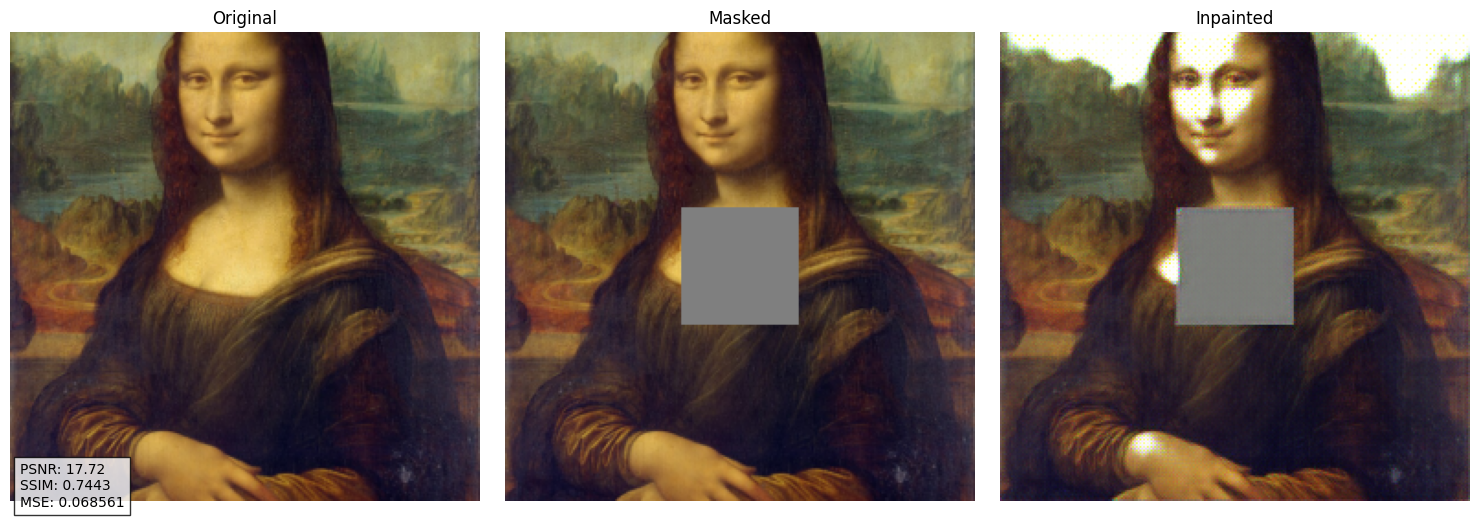

In [35]:
# Run evaluation
metrics = evaluate_model(model, 'Mona_Lisa.jpg', mask)

In [2]:
# Install required packages
!pip install pytorch_lightning
!pip install albumentations
!pip install hydra-core
!pip install transformers
!pip install huggingface_hub



In [3]:
!pip install diffusers transformers accelerate

In [4]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import numpy as np

def setup_inpainting_model():
    # Load model
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "runwayml/stable-diffusion-inpainting",
        torch_dtype=torch.float16
    ).to("cuda")
    return pipe

def inpaint_image(pipe, image_path, mask_path):
    # Load image and mask
    init_image = Image.open(image_path).convert("RGB")
    mask_image = Image.open(mask_path).convert("RGB")

    # Resize to required size (multiple of 8)
    init_image = init_image.resize((512, 512))
    mask_image = mask_image.resize((512, 512))

    # Generate inpainting
    output = pipe(
        prompt="high quality, masterpiece, detailed",
        image=init_image,
        mask_image=mask_image,
        num_inference_steps=50,
        guidance_scale=7.5
    ).images[0]

    return output

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [6]:
from PIL import Image, ImageDraw

def create_and_save_mask(width, height, output_path):
    # Create a new black image
    mask_image = Image.new("RGB", (width, height), color="black")

    # Create a draw object to draw on the mask image
    draw = ImageDraw.Draw(mask_image)

    # Define the area to inpaint (e.g., a center square)
    # Adjust these values according to your needs
    left = width // 4
    top = height // 4
    right = 3 * width // 4
    bottom = 3 * height // 4

    # Fill the inpainting area with white (or any other color)
    draw.rectangle([left, top, right, bottom], fill="white")

    # Save the mask image
    mask_image.save(output_path)


# Create and save the mask as 'mask.jpg'
create_and_save_mask(512, 512, "mask.jpg")

In [7]:
# Setup
pipe = setup_inpainting_model()

# Load your image and mask
image_path = "Mona_Lisa.jpg"
mask_path = "mask.jpg"  # Save your mask as an image

# Run inpainting
result = inpaint_image(pipe, image_path, mask_path)

# Save or display result
result.save("inpainted_result.jpg")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
import matplotlib.pyplot as plt

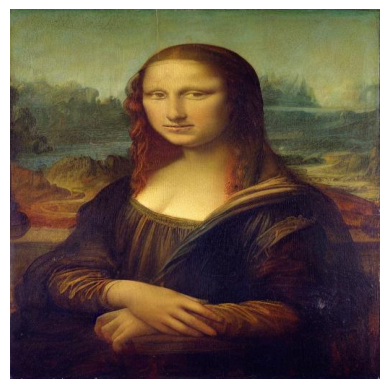

In [11]:
image = Image.open('inpainted_result.jpg')
# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()